## First real model test
### 12/12/23 jpw

In [1]:
import sys
sys.path.append("/Users/jpw/G/py/radlite/pyradlite/pyradlite/")
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Import Python-RADLite package
import radlite as RDL

In [3]:
infilename = "model.json"                    # Input file with RADLite parameters
hitranfilename = "../../data_hitran.json"     # Input file with HITRAN parameters
inspecfilename = "spectrum.json"
radmcfilepath = "./"

In [4]:
#Initialize an instance of the RadliteModel() class
myMod = RDL.RadliteModel(infilename=infilename,
                         hitranfilename=hitranfilename,
                         radmcfilepath=radmcfilepath)

FileNotFoundError: [Errno 2] No such file or directory: 'model.json'

In [5]:
#Print the number of cores assigned to this model
print(myMod.get_attr("numcores"))

#Record and print the first 10 theta points
thetas = myMod.get_attr("theta")
print(thetas[0:10])

#Print the gastodust ratio
print(myMod.get_attr("gastodust"))

#Print the name of the molecule for which RADLite will calculate fluxes
print(myMod.get_attr("molname"))

#Make sure you have correct path to the RADlite executable
myMod.get_attr("exe_path")

7
[0.04759989 0.14279967 0.23799944 0.33319922 0.428399   0.52359878
 0.61879855 0.71399833 0.80919811 0.90439789]
100.0
12CO


'/Users/jpw/G/py/radlite/RADLITE/'

In [6]:
#Print the unit for the phi-component of the velocity
print(myMod.get_unit("velocity_phi"))

#Print the unit for the radius points
print(myMod.get_unit("radius"))

cm s$^{-1}$
cm


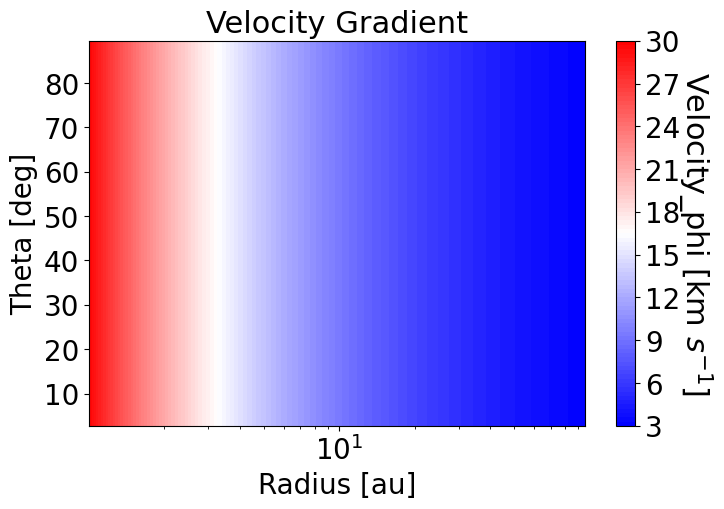

In [7]:
#Plot the gas temperature and a velocity component

figsize = (8, 5)
xlog = True 
title = "Velocity Gradient"

xscaler = 6.6846E-14      # scale the x-axis from cm to AU
xunit = "au"
yscaler = 180.0/3.14159   # scale the y-axis from radians to degrees
yunit = "deg"
zscaler = 1E-5            # scale the z-axis from cm/s to km/s
zunit = r"km $s^{-1}$"

cmap = plt.cm.bwr
levels = 100
#Uncomment the line below to manually set the levels, rather than the number of levels
#levels = [10, 20, 40, 80, 160, 320, 640] #The contour levels to use for the gradient

axisfontsize = 20
titlefontsize = 22
tickfontsize = 20

myMod.plot_attr("velocity_phi", figsize=figsize, xlog=xlog, xscaler=xscaler, xunit=xunit,
                yscaler=yscaler, yunit=yunit, zscaler=zscaler, zunit=zunit, levels=levels,
                cmap=cmap, title=title, axisfontsize=axisfontsize,
                titlefontsize=titlefontsize, tickfontsize=tickfontsize)

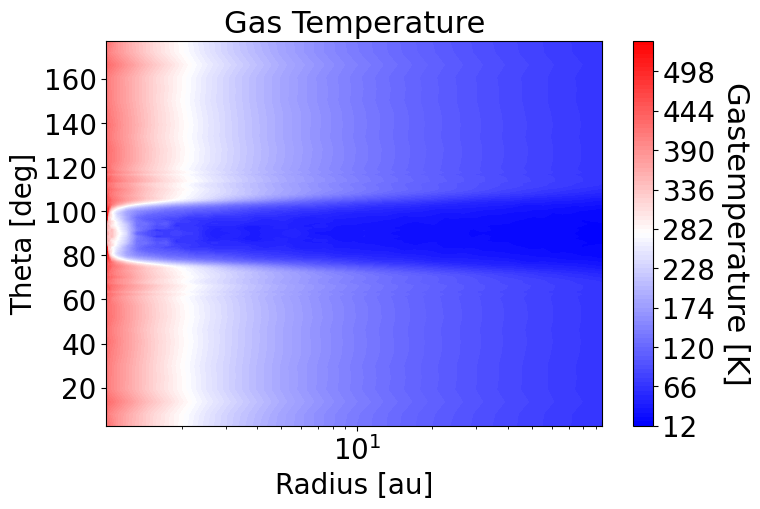

In [8]:
title = "Gas Temperature"
myMod.plot_attr("gastemperature", figsize=figsize, xlog=xlog, xscaler=xscaler, xunit=xunit,
                yscaler=yscaler, yunit=yunit, levels=levels,
                cmap=cmap, title=title, axisfontsize=axisfontsize,
                titlefontsize=titlefontsize, tickfontsize=tickfontsize,
                dosave=False, savename="Tgas.png")

## Running RADLite

In [11]:
#Run RADLite
myMod.run_radlite()

Attempting to create run directory rundir...
rundir already exists. Will overwrite files within.
All input files and final data will be saved to the following folder in the current directory: rundir
Running RADLite on 7 core(s)...
Generating working directory for cores called: ./rundir/workingdir
All core outputs will be stored in: ./rundir/outputdir
Replacing previous ./rundir/outputdir...
Prepping 0th core...
Starting 0th core in ./rundir/workingdir/workingdir_cpu0/...


mkdir: rundir: File exists
mkdir: ./rundir/outputdir: File exists


Prepping 1th core...
Starting 1th core in ./rundir/workingdir/workingdir_cpu1/...


cp: ./scatsource.dat: No such file or directory


Prepping 2th core...
Starting 2th core in ./rundir/workingdir/workingdir_cpu2/...


cp: ./scatsource.dat: No such file or directory


Prepping 3th core...
Starting 3th core in ./rundir/workingdir/workingdir_cpu3/...


cp: ./scatsource.dat: No such file or directory


Prepping 4th core...
Starting 4th core in ./rundir/workingdir/workingdir_cpu4/...


cp: ./scatsource.dat: No such file or directory


Prepping 5th core...
Starting 5th core in ./rundir/workingdir/workingdir_cpu5/...


cp: ./scatsource.dat: No such file or directory


Prepping 6th core...
Starting 6th core in ./rundir/workingdir/workingdir_cpu6/...


cp: ./scatsource.dat: No such file or directory


Done starting core(s)!


cp: ./scatsource.dat: No such file or directory


0th core has started working...
(Function _write_core_levelpopinp took 3.91e-02s.)
0th core has finished working!
(Function _run_core took 1.07e+01s.)
0th core finished and closed!
1th core has started working...
(Function _write_core_levelpopinp took 4.63e-02s.)
1th core has finished working!
(Function _run_core took 1.09e+01s.)
1th core finished and closed!
2th core has started working...
(Function _write_core_levelpopinp took 4.65e-02s.)
2th core has finished working!
(Function _run_core took 1.01e+01s.)
2th core finished and closed!
3th core has started working...
(Function _write_core_levelpopinp took 4.68e-02s.)
3th core has finished working!
(Function _run_core took 1.06e+01s.)
3th core finished and closed!
6th core has started working...
(Function _write_core_levelpopinp took 4.11e-02s.)
6th core has finished working!
(Function _run_core took 8.27e+00s.)
4th core has started working...
(Function _write_core_levelpopinp took 4.74e-02s.)
4th core has finished working!
(Function _

## Plot spectra

In [13]:
mySpec = RDL.RadliteSpectrum(infilename=inspecfilename)

--------------------------------------------------
Welcome to RADLite Version 1.3.0!

RADLite Version 1.2 (in IDL) was written by:
Klaus Pontoppidan (pontoppi@stsci.edu)
Kees Dullemond
Alex Lockwood
Rowin Meijerink

RADLite Version 1.3.0 (in Python) was written by:
Jamila Pegues (jamila.pegues@cfa.harvard.edu)
Klaus Pontoppidan (pontoppi@stsci.edu)
--------------------------------------------------



Welcome!  You have successfully initialized an instance of RadliteSpectrum(). You can use this instance to process and plot RADLite output. Start by running the gen_spec() method to process RADLite spectra.

(Function __init__ took 1.36e-03s.)


In [14]:
mySpec.gen_spec()

Starting the gen_spec method!
Reviewing user-defined parameters for spectra...
Chosen dist [pc]: 140.0
Chosen obsres [km/s]: 3.0
Chosen vsampling [km/s]: 1.5

Starting process of reading RADLite output...
Extracting all Radlite output from the following list of files: ['rundir/outputdir/']...
Starting a pool of 7 cores to extract RADLite output...
The cores have finished extracting RADLite output!

Done processing all RADLite runs!
There are a total of 41 molecular lines across all given RADLite runs.

Removing any duplicate line occurrences...
41 molecular lines are being kept.
Now there are 41 lines.

Doing light checks for signs of incompatible sources...
Light checks passed!

Done with process of reading RADLite output!

(Function _read_radliteoutput took 1.15e+00s.)
Starting to process read-in RADLite molecular line data...
NOTE: All interpolation will be done using user-specified interpolation scheme ('linear').
Broadening velocity span for each line...
Interpolating and subtract

In [15]:
#Print the number of cores assigned to this instance
print(mySpec.get_attr("numcores"))

#Print the distance to the source emitting the spectrum
print(mySpec.get_attr("dist"))

#Record and print the first 5 wavelength points
waves = mySpec.get_attr("wavelength")
print(waves[0:5])

#Record and print the first 5 wavelength points
freqs = mySpec.get_attr("frequency")
print(freqs[0:5])

#Record and print the first 5 full spectrum (emission+continuum) points
specs = mySpec.get_attr("spectrum")
print(specs[0:5])

#Record and print the first 5 emission-only points
ems = mySpec.get_attr("emission")
print(ems[0:5])

#Record and print the first 5 continuum-only points
conts = mySpec.get_attr("continuum")
print(conts[0:5])

7
140.0
[4.59872985 4.59875286 4.59877587 4.59879888 4.59882189]
[6.51902737e+13 6.51899476e+13 6.51896214e+13 6.51892952e+13
 6.51889690e+13]
[0.14078444 0.14078444 0.14078444 0.14078444 0.14078444]
[0. 0. 0. 0. 0.]
[0.14078444 0.14078444 0.14078444 0.14078444 0.14078444]


In [16]:
molinfo = mySpec.get_attr("molinfo")
ind = 5
print("Total number of molecular lines: {0}".format(len(molinfo)))
print("")
print("All information stored for the "+str(ind)+"th line: ")
print(molinfo[ind])
print("This line is molecule {0}. Its central wavenumber is {1}.  Its upper energy is {2}."
         .format(molinfo[ind]["molname"], molinfo[ind]["wavenum"], molinfo[ind]["Eup"]))

Total number of molecular lines: 41

All information stored for the 5th line: 
{'molname': '12CO', 'molweight': 28.0, 'incl': 15.0, 'gup': 9.0, 'glow': 7.0, 'A': 15.88, 'wavenum': 2158.299712, 'wavelength': 0.00046332768078504935, 'freq': 64704197576117.21, 'Eup': 2181.36921, 'Eup_K': 3138.5035806470228, 'vup': '              1', 'vlow': '              0', 'qup': '               ', 'qlow': '     R  3      '}
This line is molecule 12CO. Its central wavenumber is 2158.299712.  Its upper energy is 2181.36921.


In [17]:
#Print the units for the wavelengths and the frequencies
print(mySpec.get_unit("wavelength")) #For the wavelengths
print(mySpec.get_unit("frequency")) #For the frequencies
#
#Print the units for the full spectrum
print(mySpec.get_unit("spectrum"))

$\mu$m
Hz
Jy


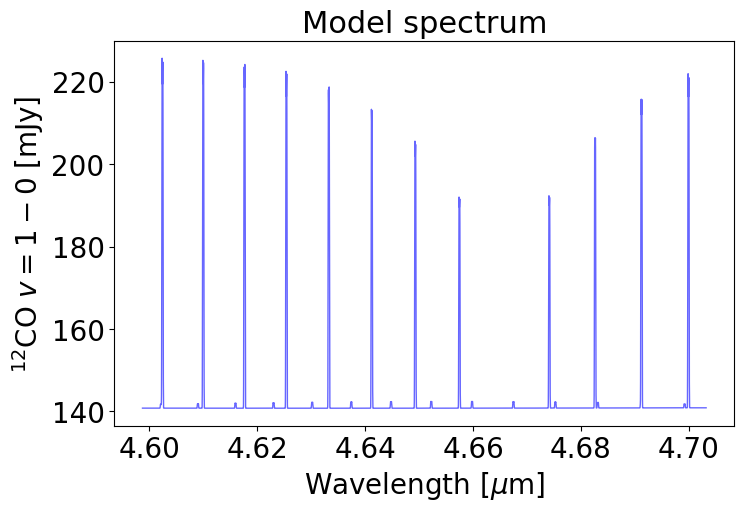

(Function plot_spec took 1.13e-01s.)


In [18]:
figsize = (8, 5)
title = "Model spectrum"

yscaler = 1000                       # scale the y-axis from Jy to mJy
ylabel = r"$^{12}$CO $v=1-0$"
yunit = "mJy"

markercolor = None
markerstyle = None
markersize = None
linecolor = "blue"
linestyle = "-"
linewidth = 1
alpha = 0.6

axisfontsize = 20
titlefontsize = 22
tickfontsize = 20
legfontsize = 20

dolegend = False
leglabel = "Full Spectrum"
legloc = "best"

mySpec.plot_spec("spectrum", figsize=figsize, yscaler=yscaler, yunit=yunit, ylabel=ylabel,
                title=title, axisfontsize=axisfontsize, titlefontsize=titlefontsize,
                tickfontsize=tickfontsize, legfontsize=legfontsize,
                markerstyle=markerstyle, markercolor=markercolor,
                markersize=markersize, linecolor=linecolor, linestyle=linestyle, alpha=alpha,
                linewidth=linewidth, leglabel=leglabel, legloc=legloc, dolegend=dolegend,
                dosave=False, savename="spectrum.png")

(Function plot_spec took 3.50e-02s.)
(Function plot_spec took 4.31e-03s.)


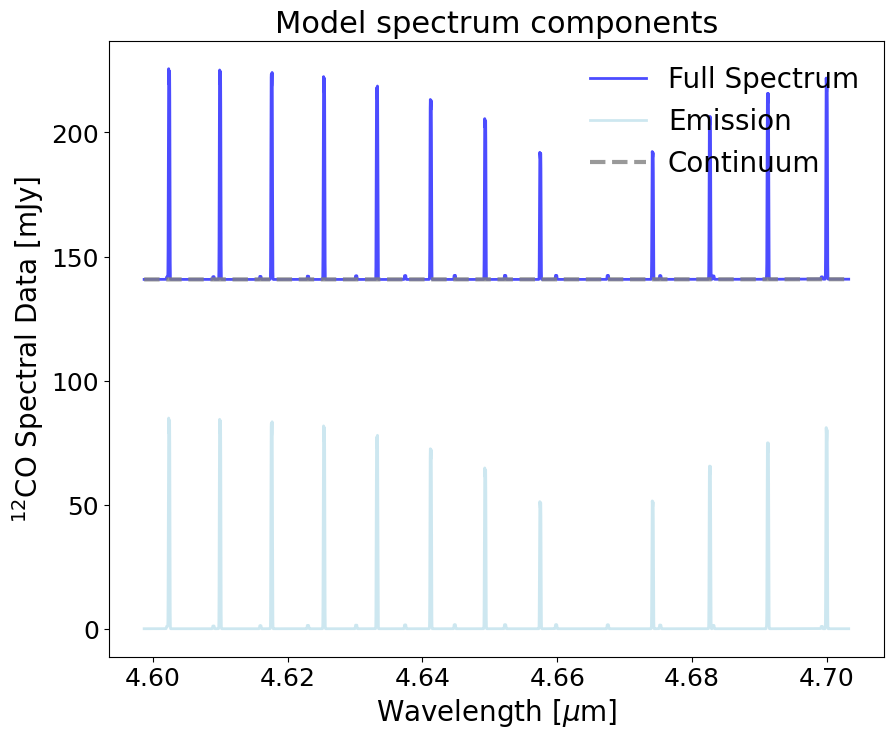

(Function plot_spec took 1.02e-01s.)


In [19]:
fig = plt.figure(figsize=(10, 8))
yscaler = 1000                     # Scale the y-axes from Jy to mJy

mySpec.plot_spec("spectrum",
                 fig=fig,
                 dopart=True,
                 linecolor="blue", linewidth=2, alpha=0.7,
                 yscaler=yscaler,
                 leglabel="Full Spectrum")

mySpec.plot_spec("emission",
                 fig=fig,
                 dopart=True,
                 linecolor="lightblue", linewidth=2, alpha=0.6, linestyle="-",
                 yscaler=yscaler,
                 leglabel="Emission")

mySpec.plot_spec("continuum",
                 fig=fig,
                 dopart=False,
                 linecolor="gray", linewidth=3, alpha=0.8, linestyle="--",
                 yscaler=yscaler,
                 ylabel=r"$^{12}$CO Spectral Data", yunit="mJy",
                 dolegend=True, legloc="upper right",
                 leglabel="Continuum",
                 axisfontsize=20, titlefontsize=22,
                 tickfontsize=18, legfontsize=20,
                 title="Model spectrum components")

In [20]:
fitsname = "specfits.fits"
overwrite = True
mySpec.write_fits(fitsname, overwrite=overwrite)

Starting the write_fits method!
Saving spectra and molecular info in a .fits file...
Data has been successfully saved to specfits.fits!
(Function write_fits took 3.73e-02s.)
